In [ ]:
#!pip install --quiet git+https://github.com/songlab-cal/gpn

In [6]:
from gpn.star.data import GenomeMSA, Tokenizer
import gpn.star.model
from gpn.star.utils import find_directory_sum_paths

import numpy as np
import pandas as pd
import torch
from transformers import AutoModel, AutoConfig, AutoModelForMaskedLM
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
WORKING_DIR = '/accounts/grad/czye/GPN/gpn/analysis/gpn-star/train_and_eval/results/'

FILE_PATHS = {}

FILE_PATHS['V'] = {
    'model_path': WORKING_DIR + 'checkpoints/hg38/fire_1/0.2/multiz100way/100/128/64/True/defined.phastCons100way.percentile-75_0.05_0.001/large/0.1/42/200000/True/True/0.1',
    'msa_path': WORKING_DIR + 'msa/hg38/multiz100way/100',
    'phylo_info_path': WORKING_DIR + 'phylo_info/hg38/multiz100way/100/phylo_dist/0.2',
}

FILE_PATHS['M'] = {
    'model_path': WORKING_DIR + 'checkpoints/hg38/fire_1/0.05/cactus447way/447/256/128/True/defined.phastCons470way.percentile-75_0.05_0.001/large/0.1/42/200000/True/True/0.1',
    'msa_path': WORKING_DIR + 'msa/hg38/cactus447way/447',
    'phylo_info_path': WORKING_DIR + 'phylo_info/hg38/cactus447way/447/phylo_dist/0.05',
}

FILE_PATHS['P'] = {
    'model_path': WORKING_DIR + 'hg38/fire_1/0.05/cactus447way/243/256/128/True/defined.phastCons43way.percentile-75_0.05_0.001/large/0.1/42/200000/True/True/0.2',
    'msa_path': WORKING_DIR + 'msa/hg38/cactus447way/243',
    'phylo_info_path': WORKING_DIR + 'phylo_info/hg38/cactus447way/243/phylo_dist/0.05',
}

In [4]:
TIME_SCALE = 'V' # 'M' # 'P'

# Load input data

Example region: chr6:31575665-31575793

[UCSC Genome Browser view](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr6%3A31575665%2D31575793&hgsid=1726885238_vIMnX2NGEluaKCXVZjeTkj97aydM) 

In [7]:
msa_paths = find_directory_sum_paths(FILE_PATHS[TIME_SCALE]['msa_path'])
genome_msa_list = [GenomeMSA(path, n_species=n_species, in_memory=False) for n_species, path in msa_paths.items()]

Loading MSA...
Loading MSA... Done


In [6]:
##### Use both the forward and reverse strand #####
# msa_fwd, msa_rev = zip(*[
#     genome_msa.get_msa_batch_fwd_rev(chrom, start, end, tokenize=True)
#     for genome_msa in self.genome_msa_list
# ])
# msa_fwd = np.concatenate(msa_fwd, axis=-1)
# msa_rev = np.concatenate(msa_rev, axis=-1)

In [8]:
raw_msa = [genome_msa.get_msa("6", 31575665, 31575793, strand="+", tokenize=False) for genome_msa in genome_msa_list]
raw_msa = np.concatenate(raw_msa, axis=-1)
print(raw_msa.shape)
raw_msa

(128, 100)


array([[b'A', b'A', b'A', ..., b'-', b'-', b'-'],
       [b'C', b'C', b'C', ..., b'-', b'-', b'-'],
       [b'A', b'A', b'A', ..., b'-', b'-', b'-'],
       ...,
       [b'T', b'T', b'T', ..., b'-', b'-', b'-'],
       [b'C', b'C', b'C', ..., b'-', b'-', b'-'],
       [b'C', b'C', b'C', ..., b'-', b'-', b'-']],
      shape=(128, 100), dtype='|S1')

In [9]:
msa = [genome_msa.get_msa("6", 31575665, 31575793, strand="+", tokenize=True) for genome_msa in genome_msa_list]
msa = np.concatenate(msa, axis=-1)
print(msa.shape)
msa

(128, 100)


array([[1, 1, 1, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [4, 4, 4, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], shape=(128, 100), dtype=uint8)

In [10]:
msa = torch.tensor(np.expand_dims(msa, 0).astype(np.int64))
msa

tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [4, 4, 4,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0],
         [2, 2, 2,  ..., 0, 0, 0]]])

In [11]:
# define human as the target species and use all species as source species
input_ids, source_ids = msa[:, :, :1], msa
input_ids.shape, source_ids.shape

(torch.Size([1, 128, 1]), torch.Size([1, 128, 100]))

# Get logits

In [12]:
config = AutoConfig.from_pretrained(FILE_PATHS[TIME_SCALE]['model_path'])

In [13]:
config.phylo_dist_path = FILE_PATHS[TIME_SCALE]['phylo_info_path']

In [14]:
model_for_mlm = AutoModelForMaskedLM.from_pretrained(FILE_PATHS[TIME_SCALE]['model_path'], config=config)
model_for_mlm.eval()

GPNStarForMaskedLM(
  (model): GPNStarModel(
    (target_embedding): GPNStarEmbedding(
      (input_embed): Embedding(6, 1024)
    )
    (source_embedding): GPNStarSourceModule(
      (attn_pool): GPNStarAttentionPool(
        (attention_weights): Embedding(6, 8)
        (value): Embedding(6, 512)
        (dropout): Dropout(p=0.1, inplace=False)
        (ffn): Linear(in_features=512, out_features=1024, bias=True)
      )
      (embed): Embedding(6, 1024)
      (embed_positions): FIRETimeBias(
        (mlp): Sequential(
          (0): Linear(in_features=1, out_features=32, bias=False)
          (1): SiLU()
          (2): Linear(in_features=32, out_features=1, bias=False)
        )
      )
    )
    (encoder): GPNStarEncoder(
      (embed_positions): RoFormerSinusoidalPositionalEmbedding(1536, 64)
      (layer): ModuleList(
        (0-15): 16 x GPNStarLayer(
          (attention): GPNStarAttention(
            (row_attention): GPNStarRowAttention(
              (self): GPNStarRowSelfAtte

In [15]:
raw_msa[76:79, 0]  # Start codon

array([b'A', b'T', b'G'], dtype='|S1')

In [16]:
tokenizer = Tokenizer()
pos = 76  # Let's mask the A and check the model predictions
input_ids[0, pos] = tokenizer.mask_token_id()

In [17]:
input_ids.shape

torch.Size([1, 128, 1])

In [18]:
with torch.no_grad():
    all_logits = model_for_mlm.forward(input_ids=input_ids, 
                                       source_ids=source_ids, 
                                       target_species=np.array([[0]], dtype=int)).logits
all_logits.shape # (batch_size, seq_len, num_target, vocab_size)

/accounts/grad/czye/conda/envs/gpn_env/envs/gpn_star/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


torch.Size([1, 128, 1, 6])

In [19]:
nucleotides = list('ACGT')
logits = all_logits.squeeze()[pos, [tokenizer.vocab.index(nc) for nc in nucleotides]]
logits

tensor([ 7.7062, -1.9220, -0.6912, -2.6507])

In [20]:
probs = torch.nn.functional.softmax(logits, dim=0).numpy()
probs

array([9.9967706e-01, 6.5820524e-05, 2.2536943e-04, 3.1760745e-05],
      dtype=float32)

<Axes: xlabel='nucleotide', ylabel='probability'>

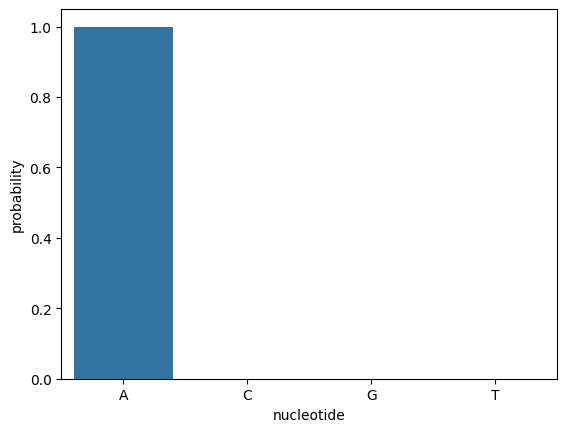

In [21]:
probs_df = pd.DataFrame(dict(nucleotide=nucleotides, probability=probs))
sns.barplot(data=probs_df, x="nucleotide", y="probability")